In [20]:
from datasets import load_dataset, Audio
import pandas as pd
import matplotlib.pyplot as plt
import json

In [21]:
with open("./config.json", mode = "r") as f:
    data = json.load(f)
    SAMPLING_RATE = data["sampling_rate"]
    SEGMENT_LEN = data["segment_length"]
    OVERLAP_LEN = data["overlap_length"]

In [22]:
dataset = load_dataset("Saads/xecanto_birds")
dataset

Resolving data files:   0%|          | 0/11032 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'primary_label', 'secondary_labels', 'type', 'latitude', 'longitude', 'scientific_name', 'common_name', 'author', 'license', 'rating', 'url'],
        num_rows: 11031
    })
})

In [23]:
dataset = dataset.remove_columns([
    "primary_label",
    "secondary_labels",
    "scientific_name",
    "author",
    "license",
    "rating",
    "type",
    "latitude",
    "longitude",
    "url"
])
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'common_name'],
        num_rows: 11031
    })
})

In [24]:
dataset = dataset.class_encode_column("common_name")

In [6]:
# common_names = dataset["train"].features["common_name"].names
# common_names

In [7]:
def chunk_audio(audio_array, chunk_length = SEGMENT_LEN, overlap = OVERLAP_LEN):
    chunk_length = chunk_length * SAMPLING_RATE
    overlap = overlap * SAMPLING_RATE

    counter = 0
    start = 0
    while start + chunk_length <= len(audio_array):
        counter += 1
        start += (chunk_length - overlap)
    
    if start < len(audio_array):
        counter += 1
    
    return counter

In [8]:
def preprocess(row):
    counter = chunk_audio(row["audio"]["array"])
    return {"num_audio_chunks": counter}

In [9]:
dataset = dataset.cast_column("audio", Audio(sampling_rate = SAMPLING_RATE))
dataset = dataset.map(
    preprocess,
    remove_columns = "audio",
    batched = False,
    num_proc = 16,
    writer_batch_size = 200
)

Map (num_proc=16):   0%|          | 0/11031 [00:00<?, ? examples/s]

In [10]:
df_chunked = dataset["train"].to_pandas()
df_chunked

,common_name,num_audio_chunks
0,1,6
1,1,3
2,1,5
3,1,4
4,1,6
...,...,...
11026,263,9
11027,263,8
11028,263,4
11029,263,4


In [11]:
counts = df_chunked["common_name"].value_counts()

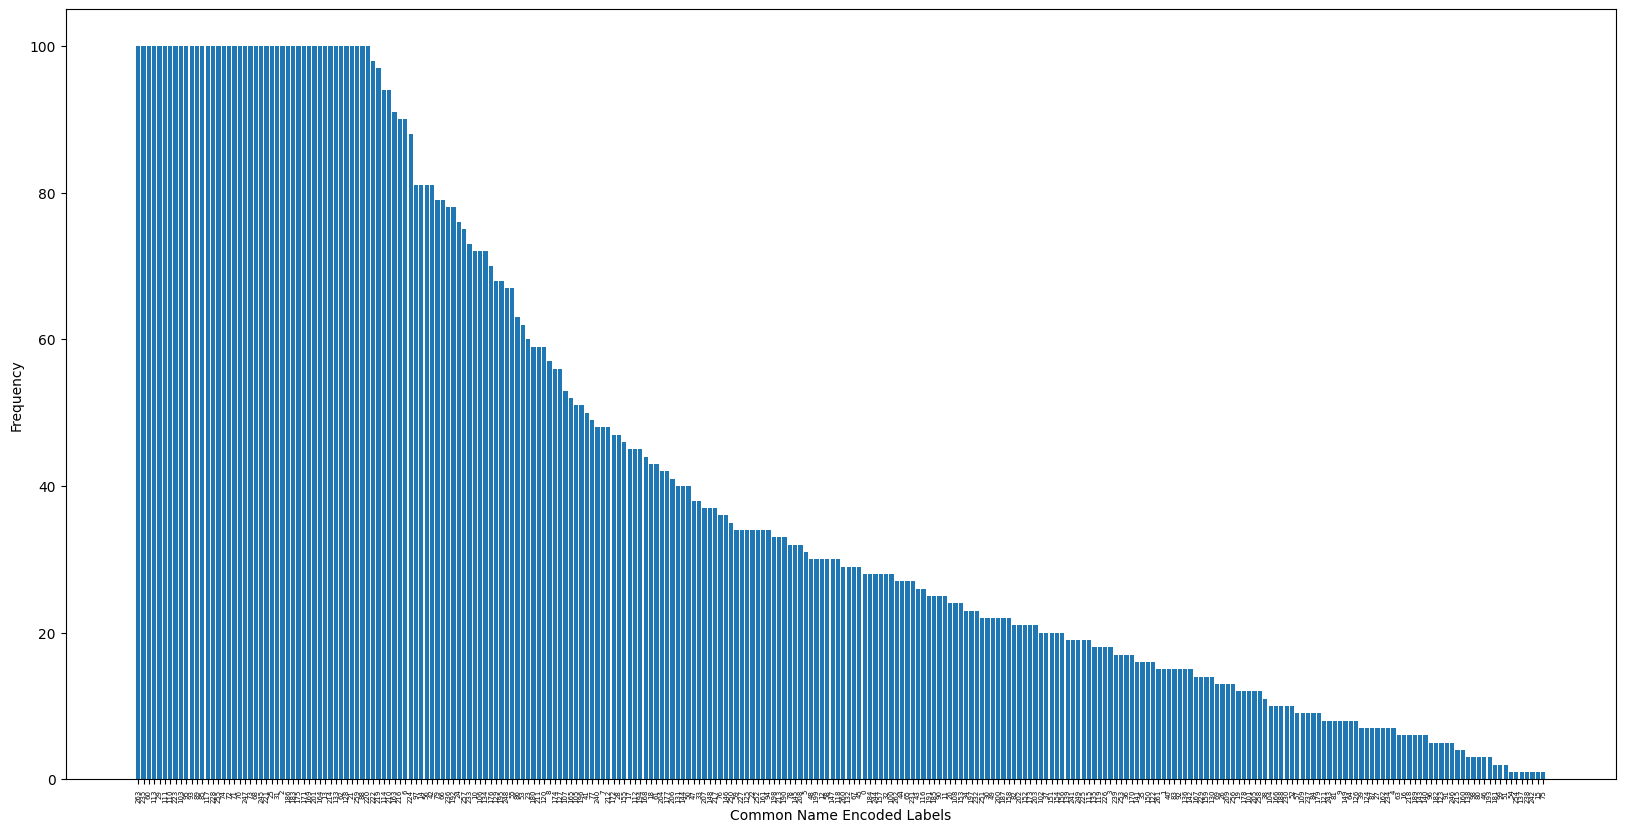

In [12]:
plt.figure(figsize = (20, 10))
plt.bar(range(len(counts)), counts.values, tick_label = counts.index.values)
plt.xlabel("Common Name Encoded Labels")
plt.ylabel("Frequency")
plt.xticks(rotation = 90, fontsize = 5)
# plt.savefig("./whole-audio-distribution.pdf", format = "pdf")
plt.show()

In [13]:
df_chunked = df_chunked.groupby("common_name").sum().sort_values(by = "num_audio_chunks", ascending = False)
df_chunked

,num_audio_chunks
common_name,
221,1187
129,926
72,894
73,881
245,871
...,...
181,3
99,2
242,2


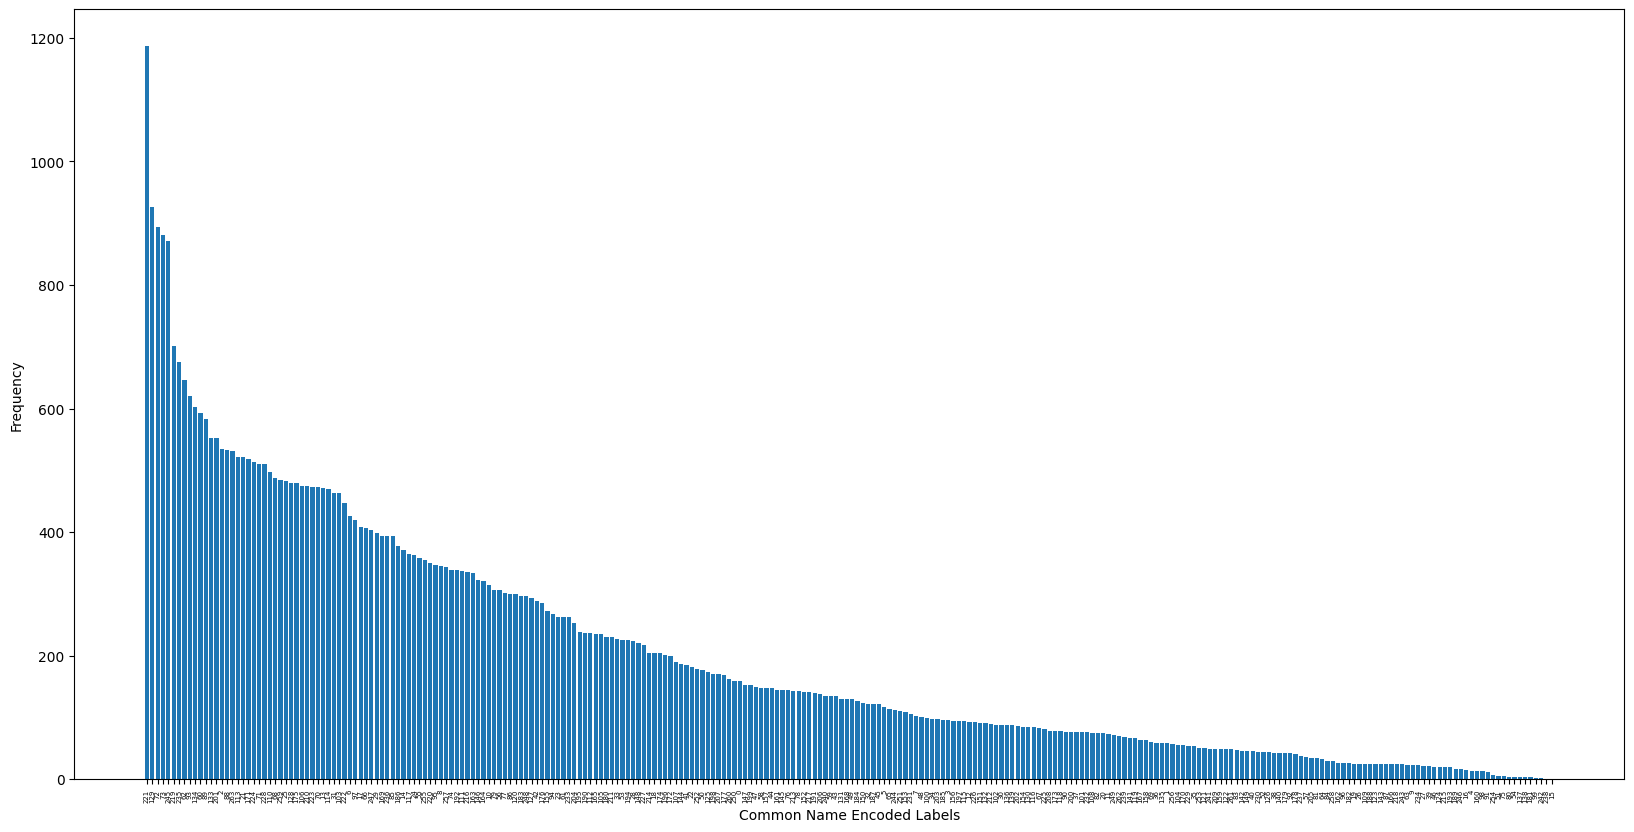

In [14]:
plt.figure(figsize = (20, 10))
plt.bar(range(len(df_chunked.index.values)), df_chunked.num_audio_chunks.values, tick_label = df_chunked.index.values)
plt.xlabel("Common Name Encoded Labels")
plt.ylabel("Frequency")
plt.xticks(rotation = 90, fontsize = 5)
# plt.savefig("./chunked-audio-distribution.pdf", format = "pdf")
plt.show()

In [19]:
df_chunked[df_chunked["num_audio_chunks"] >= 300]

,num_audio_chunks
common_name,
221,1187
129,926
72,894
73,881
245,871
...,...
164,321
10,314
79,307
